# Load The Libraries

In [2]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import math

import h5py
import cv2

from sklearn.model_selection import StratifiedShuffleSplit
import sklearn.preprocessing
from random import randint #to generate random numbers

# Declare the Dictionary

In [3]:
details = {}

details['hdf5_dataset_label'] = ['batch', 'label', 'hotlabel', 'img_name']
details['read_path'] = 'read/it/from/this/path/'
details['save_path'] = 'save/to/this/path/'
details['save_img_size'] = (300, 300, 3)

details['image_path'] = ['VW-Passat', 'RENO-Fluence', 'FIAT-Linea', 'VW-Polo',\
                              'RENO-Toros', 'FIAT-Dogan', 'OtherClass']
details['image_label'] = ['passat', 'fluence', 'linea', 'polo', 'toros', 'dogan', 'other']

# change it if it is different
details['read_prefix'] = 'preprocessed_'

details['class_number'] = len(details['image_path'])

## Shuffle Function

In [4]:
def shuffle(details, slide=4):
    # loop over train addresses
    val_values = {}
    val_values['val_x_all'] = []
    #val_values['val_y_all'] = []
    val_values['hot_val_y_all'] = []
    val_values['name_val_all'] = []

    for i in range(slide):
   
        allbatchSorted = []
        alllabelsSorted = []
        allnameSorted = []

        for class_name in details['image_path']:

            hdf5_path = details['read_path'] + details['read_prefix'] + class_name + '.hdf5'

            # opening like this, solves the problem of 'Unable to truncate a file which is already open'
            with h5py.File(hdf5_path,'r') as hdf5_file:
                batch_name_read = hdf5_file[details['hdf5_dataset_label'][0]]
                label_name_read = hdf5_file[details['hdf5_dataset_label'][1]]
                #hot_label_name_read = hdf5_file[details['hdf5_dataset_label'][2]]
                image_name_read = hdf5_file[details['hdf5_dataset_label'][3]]

                iter_range = round(len(label_name_read)/slide)
                
                allbatchSorted.extend(np.array(batch_name_read[i*iter_range : (i+1)*iter_range]))
                alllabelsSorted.extend(np.array(label_name_read[i*iter_range : (i+1)*iter_range]))
                allnameSorted.extend(np.array(image_name_read[i*iter_range : (i+1)*iter_range]))
                
        allbatchSorted = np.array(allbatchSorted)
        alllabelsSorted = np.array(alllabelsSorted)
        allnameSorted = np.array(allnameSorted)
          
        # Shuffle the dataset and then cut it in such a way that training-validation-test
        # will be distributed like 80%-10%-10% 
        ss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=3)

        train_idx, val_idx = next(ss.split(allbatchSorted, alllabelsSorted))
    
        # one-hot-encode
        a = [0,1,2,3,4,5,6]
        label_binarizer = sklearn.preprocessing.LabelBinarizer()
        label_binarizer.fit(range(max(a)+1))
        hot_labels_vecs = label_binarizer.transform(a)
                
        train_x, hot_train_y = allbatchSorted[train_idx], hot_labels_vecs[alllabelsSorted[train_idx]]
        name_train = allnameSorted[train_idx]
        
        val_x, hot_val_y = allbatchSorted[val_idx], hot_labels_vecs[alllabelsSorted[val_idx]]
        name_val = allnameSorted[val_idx]
        
        val_values['val_x_all'].extend(val_x)
        #val_values['val_y_all'].extend(val_y)
        val_values['hot_val_y_all'].extend(hot_val_y)
        val_values['name_val_all'].extend(name_val)
       
        print("Train" + str(i+1) + " shapes (x, y):", train_x.shape, hot_train_y.shape)
                  
        hdf5_path = save_path + 'train' + str(i+1) + '.hdf5'
            
        with h5py.File(hdf5_path,'w') as hdf5_file:
                
            train_shape = (len(hot_train_y), save_img_size[0], save_img_size[1], save_img_size[2])
            hdf5_file.create_dataset(details['hdf5_dataset_label'][0], train_shape, np.uint8)                
            hdf5_file[details['hdf5_dataset_label'][0]][...] = train_x
                
            #hdf5_file.create_dataset(details['hdf5_dataset_label'][1], (len(train_y), ), np.uint8)
            #hdf5_file[details['hdf5_dataset_label'][1]][...] = train_y
                
            hdf5_file.create_dataset(details['hdf5_dataset_label'][2], (len(hot_train_y), details['class_number'], ), np.uint8)
            hdf5_file[details['hdf5_dataset_label'][2]][...] = hot_train_y
                
            dt = h5py.special_dtype(vlen=bytes)
            hdf5_file.create_dataset(details['hdf5_dataset_label'][3], (len(hot_train_y), ), dtype=dt)
            hdf5_file[details['hdf5_dataset_label'][3]][...] = name_train
            
        if i == 1 or i == 3:
            
            val_values['val_x_all'] = np.array(val_values['val_x_all'])
            #val_values['val_y_all'] = np.array(val_values['val_y_all'])
            val_values['hot_val_y_all'] = np.array(val_values['hot_val_y_all'])
            val_values['name_val_all'] = np.array(val_values['name_val_all'])
            
            if i == 1:
                hdf5_path = save_path + 'val' + '.hdf5'
                print("Validation shapes (x, y):", val_values['val_x_all'].shape, val_values['hot_val_y_all'].shape)
            else:
                hdf5_path = save_path + 'test' + '.hdf5'
                print("Test shapes (x, y):", val_values['val_x_all'].shape, val_values['hot_val_y_all'].shape)
                     
            with h5py.File(hdf5_path,'w') as hdf5_file:
                
                train_shape = (len(val_values['hot_val_y_all']), details['save_img_size'][0], details['save_img_size'][1], details['save_img_size'][2])
                hdf5_file.create_dataset(details['hdf5_dataset_label'][0], train_shape, np.uint8)
                hdf5_file[details['hdf5_dataset_label'][0]][...] = val_values['val_x_all']

                #hdf5_file.create_dataset(details['hdf5_dataset_label'][1], (len(val_values['val_y_all']), ), np.uint8)
                #hdf5_file[details['hdf5_dataset_label'][1]][...] = val_values['val_y_all']

                hdf5_file.create_dataset(details['hdf5_dataset_label'][2], (len(val_values['hot_val_y_all']), details['class_number'], ), np.uint8)
                hdf5_file[details['hdf5_dataset_label'][2]][...] = val_values['hot_val_y_all']

                dt = h5py.special_dtype(vlen=str)
                hdf5_file.create_dataset(details['hdf5_dataset_label'][3], (len(val_values['hot_val_y_all']), ), dtype=dt)
                hdf5_file[details['hdf5_dataset_label'][3]][...] = val_values['name_val_all']
            
            val_values['val_x_all'] = []
            #val_values['val_y_all'] = []
            val_values['hot_val_y_all'] = []
            val_values['name_val_all'] = []


In [6]:
shuffle(details, slide=4)

Train1 shapes (x, y): (5754, 300, 300, 3) (5754, 7)
Train2 shapes (x, y): (5754, 300, 300, 3) (5754, 7)
Validation shapes (x, y): (2878, 300, 300, 3) (2878, 7)
Train3 shapes (x, y): (5754, 300, 300, 3) (5754, 7)
Train4 shapes (x, y): (5747, 300, 300, 3) (5747, 7)
Test shapes (x, y): (2876, 300, 300, 3) (2876, 7)


# READ & TEST

In [7]:
def show_test(hdf5_path, details):
    
    with h5py.File(hdf5_path,'r') as hdf5_file:
        # open the hdf5 file
        # Total number of samples
        X_train = hdf5_file[details['hdf5_dataset_label'][0]]
        #Y_label_train = hdf5_file[details['hdf5_dataset_label'][1]]
        Y_hot_label_train = hdf5_file[details['hdf5_dataset_label'][2]]
        img_name = hdf5_file[details['hdf5_dataset_label'][3]]

        random_index = randint(0,len(Y_hot_label_train))

        img = X_train[random_index]
        print('Image name : ' + str(img_name[random_index]))
        print('Length : ' + str(len(X_train)))
        plt.imshow(img)
        plt.show()

        print('Hot label : ' + str(Y_hot_label_train[random_index]))
        print('Label index : ' + str(np.argmax(Y_hot_label_train[random_index])))
        print('Label class : ' + image_label[np.argmax(Y_hot_label_train[random_index])])
        
        print(img)

Image name : polo1000.jpg
Length : 5754


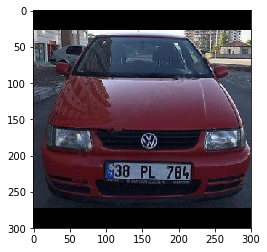

Hot label : [0 0 0 1 0 0 0]
Label index : 3
Label class : polo
[[[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 ..., 
 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]

 [[ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  ..., 
  [ 0.  0.  0.]
  [ 0.  0.  0.]
  [ 0.  0.  0.]]]


In [49]:
hdf5_path = 'read/it/from/this/path/train2.hdf5'

show_test(hdf5_path, details)